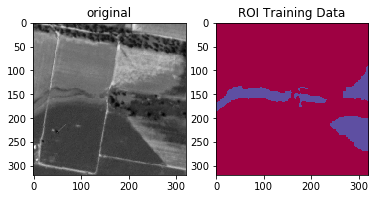

In [1]:
# Import Python 3's print function and division
from __future__ import print_function, division

# Import GDAL, NumPy, and matplotlib
from osgeo import gdal, gdal_array
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Tell GDAL to throw Python exceptions, and register all drivers
gdal.UseExceptions()
gdal.AllRegister()

# Read in our image and ROI image
img_ds = gdal.Open('R:/Work/medieval 2017/FDSI Dev/devset_01_satellite_images/010627.tif', gdal.GA_ReadOnly)
roi_ds = gdal.Open('R:/Work/medieval 2017/FDSI Dev/devset_01_segmentation_masks/seg_mask_010627.png', gdal.GA_ReadOnly)

img = np.zeros((img_ds.RasterYSize, img_ds.RasterXSize, img_ds.RasterCount),
               gdal_array.GDALTypeCodeToNumericTypeCode(img_ds.GetRasterBand(1).DataType))
for b in range(img.shape[2]):
    img[:, :, b] = img_ds.GetRasterBand(b + 1).ReadAsArray()
    
roi = roi_ds.GetRasterBand(1).ReadAsArray()

# Display them
plt.subplot(121)
plt.imshow(img[:, :, 1], cmap=plt.cm.Greys_r)
plt.title('original')

plt.subplot(122)
plt.imshow(roi, cmap=plt.cm.Spectral)
plt.title('ROI Training Data')

plt.show()

In [2]:
# Find how many non-zero entries we have -- i.e. how many training data samples?
n_samples = (roi>=0).sum()
print('We have {n} samples'.format(n=n_samples))

# What are our classification labels?
labels = np.unique(roi)
print('The training data include {n} classes: {classes}'.format(n=labels.size, 
                                                                classes=labels))
# We will need a "X" matrix containing our features, and a "y" array containing our labels
#     These will have n_samples rows
#     In other languages we would need to allocate these and them loop to fill them, but NumPy can be faster

X = img[roi >= 0] 
y = roi[roi >= 0]

print('Our X matrix is sized: {sz}'.format(sz=X.shape))
print('Our y array is sized: {sz}'.format(sz=y.shape))


print('After masking, our X matrix is sized: {sz}'.format(sz=X.shape))
print('After masking, our y array is sized: {sz}'.format(sz=y.shape))

We have 102400 samples
The training data include 2 classes: [0 1]
Our X matrix is sized: (102400, 4)
Our y array is sized: (102400,)
After masking, our X matrix is sized: (102400, 4)
After masking, our y array is sized: (102400,)


In [3]:
from sklearn.svm import SVC
clf = SVC(C=1.0, kernel='linear', degree=3, gamma='auto', coef0=0.0, shrinking=True, probability=False, tol=0.001, cache_size=200, class_weight=None, verbose=False, max_iter=10000000, decision_function_shape='ovr', random_state=None)
SVM=clf.fit(X,y)

C:\Users\n9870059\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\svm\base.py:220: ConvergenceWarning: Solver terminated early (max_iter=10000000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


In [4]:
import pandas as pd

# Setup a dataframe -- just like R
df = pd.DataFrame()
df['truth'] = y
df['predict'] = SVM.predict(X)

# Cross-tabulate predictions
print(pd.crosstab(df['truth'], df['predict'], margins=True))


predict      0     1     All
truth                       
0        91148   992   92140
1         2381  7879   10260
All      93529  8871  102400


In [10]:
raster_data_path = "R:/Work/medieval 2017/FDSI Dev/devset_01_satellite_images/013125.tif"
raster_dataset = gdal.Open(raster_data_path, gdal.GA_ReadOnly)
geo_transform = raster_dataset.GetGeoTransform()
proj = raster_dataset.GetProjectionRef()
bands_data = []
for b in range(1, raster_dataset.RasterCount+1):
    band = raster_dataset.GetRasterBand(b)
    bands_data.append(band.ReadAsArray())

bands_data = np.dstack(bands_data)
rows, cols, n_bands = bands_data.shape
n_samples = rows*cols
flat_pixels = bands_data.reshape((n_samples, n_bands))
result_SVM = SVM.predict(flat_pixels)

In [12]:
np.unique (result_SVM)

array([0, 1], dtype=uint8)

In [13]:
from sklearn.ensemble import RandomForestClassifier

# Initialize our model with 500 trees
rf = RandomForestClassifier(n_estimators=500, oob_score=True)

# Fit our model to training data
rf = rf.fit(X, y)

In [14]:
df = pd.DataFrame()
df['truth'] = y
df['predict'] = rf.predict(X)

# Cross-tabulate predictions
print(pd.crosstab(df['truth'], df['predict'], margins=True))

predict      0      1     All
truth                        
0        92140      0   92140
1            0  10260   10260
All      92140  10260  102400


In [15]:
result_RF = rf.predict(flat_pixels)

In [16]:
np.unique (result_RF)

array([0, 1], dtype=uint8)

In [17]:
from sklearn.naive_bayes import GaussianNB
mlc = GaussianNB()
MLC=mlc.fit(X,y)

In [18]:
df = pd.DataFrame()
df['truth'] = y
df['predict'] = MLC.predict(X)

# Cross-tabulate predictions
print(pd.crosstab(df['truth'], df['predict'], margins=True))

predict      0      1     All
truth                        
0        90009   2131   92140
1         1740   8520   10260
All      91749  10651  102400


In [19]:
result_MLC = MLC.predict(flat_pixels)

In [20]:
np.unique (result_MLC)

array([0, 1], dtype=uint8)

In [26]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import VotingClassifier

    

In [27]:
eclf = VotingClassifier(estimators=[('lr', SVM), ('rf', rf), ('gnb', MLC)], voting='hard')

In [30]:
for clf, label in zip([SVM, rf, MLC, eclf], ['SVM', 'RF', 'MLC', 'Ensemble']):
    scores = cross_val_score(clf, X, y, cv=5, scoring='accuracy')
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))

C:\Users\n9870059\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\svm\base.py:220: ConvergenceWarning: Solver terminated early (max_iter=10000000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\n9870059\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\svm\base.py:220: ConvergenceWarning: Solver terminated early (max_iter=10000000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\n9870059\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\svm\base.py:220: ConvergenceWarning: Solver terminated early (max_iter=10000000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\n9870059\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\svm\base.py:220: ConvergenceWarning: Solver terminated early (max_iter=10000000).  Consider pre-processing yo

Accuracy: 0.97 (+/- 0.02) [SVM]
Accuracy: 0.96 (+/- 0.02) [RF]
Accuracy: 0.96 (+/- 0.02) [MLC]


TypeError: Cannot clone object 'array([1, 0, 1, ..., 1, 1, 1], dtype=uint8)' (type <class 'numpy.ndarray'>): it does not seem to be a scikit-learn estimator as it does not implement a 'get_params' methods.